In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.sparse import csr_matrix
from tqdm import tqdm
import scipy.sparse as sp
from scipy.sparse import diags
from scipy.linalg import lu_factor, lu_solve
from functools import lru_cache
from scipy.linalg import solve


In [33]:
file_path = os.path.expanduser("~/transmission_results/")

In [34]:
os.scandir(file_path)

In [11]:

def unitcell(w, d, t, e, m):
    dim = 2 * m

    base_val = (w + 1j*d)

    base = base_val * np.eye(2*m)

    idy = np.arange(0,2*m-1,1)

    base[idy,idy+1] = t
    base[idy+1,idy] = t

    idx = np.arange(0,m,2)

    base[idx,2*m-1-idx] = t
    base[2*m-1-idx,idx] = t

    return base 


def connection(t,m):
    idx = np.arange(2,m,2)
    base = np.zeros((2*m,2*m),dtype=np.complex64)

    base[2*m - idx,idx - 1] = t 

    return base



def T1_matrix(t, m):
    dim = 2 * m
    T = np.zeros((dim, dim), dtype=np.complex128)

    n = np.arange(1, (m - 1)//2 + 1)
    i = 2*n - 1           # to 0-based
    j = 2*m - 2*n

    T[i, j] = t
    return T


In [13]:
# ----------------------------------------------------------------------
# 1) Precomputed global cache of device_combs per width
# ----------------------------------------------------------------------
DEVICE_COMBS = {}


def _get_device_combs(width: int) -> np.ndarray:
    """
    Return (global cached) device combinations for a given width.
    Each row is (i, j) with i in [0..99] and j in [0..width-1].
    """
    width = int(2*width)
    if width not in DEVICE_COMBS:
        # Build once, store once
        DEVICE_COMBS[width] = np.stack(
            np.meshgrid(np.arange(100), np.arange(width), indexing="ij"),
            axis=-1
        ).reshape(-1, 2)
    return DEVICE_COMBS[width]


# ----------------------------------------------------------------------
# 2) Cached selection of N random impurity sites for a given config
# ----------------------------------------------------------------------
@lru_cache(maxsize=2048)
def chosen_for_config(n: int, width: int, config: int) -> np.ndarray:
    """
    Return n rows selected deterministically by given config.
    Completely cached.
    """
    n = int(n)
    width = int(width)
    config = int(config)

    device_combs = _get_device_combs(width)

    rng = np.random.RandomState(config)
    idx = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[idx]


# ----------------------------------------------------------------------
# 3) Factory: returns function(seed) → chosen impurity rows
# ----------------------------------------------------------------------
def possible_combs(n: int, width: int):
    n = int(n)
    width = int(width)

    def combs_for_seed(seed: int):
        return chosen_for_config(n, width, seed)

    return combs_for_seed


# ----------------------------------------------------------------------
# 4) Device builder
# ----------------------------------------------------------------------
def unidevice(w, d, t, e, size, config, n, numberofunitcell, combs_fn=None):
    """
    Build a device Hamiltonian unit with impurities inserted at positions
    determined by 'config'. Uses vectorised assignments where possible.
    """

    size = int(size)

    
    if combs_fn is None:
        combs_fn = possible_combs(int(n), int(size))

    # Chosen impurity coordinates
    imps = combs_fn(int(config))
    x = imps[:, 0]
    y = imps[:, 1]

    z = int(numberofunitcell)

    # Base Hamiltonian (already cached inside your unitcell_leads)
    mat = unitcell(w, d, t, e, int(size))

    # Identify impurities in unitcell z
    mask = (x == z)
    if not np.any(mask):
        return mat  # fast path return

    imp_indices = y[mask]

    # Vectorised diagonal modification
    diag_val = (w + 1j*d - 0.5)
    mat[imp_indices, imp_indices] = diag_val

    return mat


In [55]:
possible_combs(5, 7)(10001)

array([[40,  0],
       [11, 13],
       [23,  3],
       [31, 10],
       [10,  0]])

In [20]:
leads_path = os.getcwd()
print(leads_path)

/home/shardul/machine_learning/transmission_github/transmissions/notebooks


In [27]:
g_7 = np.load(
    os.path.expanduser('~/machine_learning/transmission_github/transmissions/leads/agnr_7.npy')
)


In [28]:


def device_transmission(w, d, t, e,size,config,concentration):
    ene = int(w*100)



    m = size    


    left = g_7[ene]     # left lead surface Green's function
    right = g_7[ene]     # right lead

    T  = connection(t,m)

    I = np.eye(2*m, dtype=complex)
    Td = T.conj().T
    

    tin =  T1_matrix(t, m)

    tin_d = tin.T


    combs_fn = possible_combs(concentration,size)

    g_new = left


    for i in range(100):
        
        unit = unidevice(w, d, t, e, size, config, concentration, i, combs_fn=combs_fn)
#        print(unit.shape)
        gd = np.linalg.inv(unit)

        G = np.linalg.solve(I - gd @ tin_d @ g_new @ tin, gd)

        g_new = G


    left_device = g_new

    IL = np.linalg.solve(I - left_device @ Td @ right @ Td, left_device)
    IR = np.linalg.solve(I - right @ Td @ left_device @ Td, right)
    gdd = IL - IL.conj().T
    grr = IR - IR.conj().T

    Gnonlocal = right @ Td @ IL
    GNON = Gnonlocal - Gnonlocal.conj().T

    term1 = gdd @ T @ grr @ Td
    term2 = T @ GNON @ Td @ GNON

    tr1 = np.abs(np.trace(term1 - term2))

    return tr1


In [31]:
pristine = [device_transmission(w,0.0001,1,0,7,0,0) for w in np.arange(0,3,0.01)]

In [44]:
@lru_cache(1028)
def ca(conc):
    df = []
    d1 = [np.clip(np.load(os.path.join(file_path + f'7_agnr_conc{conc}_cfg{config}.npy')), 0, pristine) for config in range(10000)]
    df.append(d1)

    return np.mean(df, axis=1)



In [75]:
ca(5)[0]

array([4.00000798e-01, 3.96703177e-03, 1.00566140e-03, 4.52556547e-04,
       2.58734097e-04, 1.69089993e-04, 1.20506158e-04, 9.13685039e-05,
       7.26282310e-05, 5.99697396e-05, 5.11450223e-05, 4.48696805e-05,
       4.04122149e-05, 3.73309395e-05, 3.53777809e-05, 3.44502493e-05,
       3.45842059e-05, 3.59974187e-05, 3.92191504e-05, 4.54872300e-05,
       5.79475315e-05, 8.65890302e-05, 1.80301274e-04, 1.16451661e-03,
       5.90172390e-01, 7.81538546e-01, 8.43541518e-01, 8.77380599e-01,
       8.96157754e-01, 9.37537553e-01, 9.18605265e-01, 9.24091070e-01,
       9.30572517e-01, 9.35263310e-01, 9.38850824e-01, 9.41973753e-01,
       9.44884915e-01, 9.46864951e-01, 9.49669829e-01, 9.52459326e-01,
       9.54702002e-01, 9.49066962e-01, 1.12721195e+00, 1.48836758e+00,
       1.61929957e+00, 1.68423922e+00, 1.72521814e+00, 1.75308020e+00,
       1.77342559e+00, 1.78922777e+00, 1.80250133e+00, 1.81306270e+00,
       1.82169548e+00, 1.82660528e+00, 1.83459509e+00, 1.83920415e+00,
      

In [ ]:
device_transmission(0,0.0001,1,0,7,)

In [168]:
configs =  np.arange(10001,10100,1)
configs

array([10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009,
       10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018,
       10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027,
       10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036,
       10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045,
       10046, 10047, 10048, 10049, 10050, 10051, 10052, 10053, 10054,
       10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062, 10063,
       10064, 10065, 10066, 10067, 10068, 10069, 10070, 10071, 10072,
       10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081,
       10082, 10083, 10084, 10085, 10086, 10087, 10088, 10089, 10090,
       10091, 10092, 10093, 10094, 10095, 10096, 10097, 10098, 10099])

In [169]:
data_test = {}

conc = np.arange(1,50,3)

for con in conc:
    print(f"working on {con}")
    data_test[con] = [[device_transmission(w,0.0001,1,0,7,conf,con) for w in np.arange(0,3,0.01)] for conf in configs]

working on 1
working on 4
working on 7
working on 10
working on 13
working on 16
working on 19
working on 22
working on 25
working on 28
working on 31
working on 34
working on 37
working on 40
working on 43
working on 46
working on 49


In [170]:
def misfit(conc):
    configs = data_test[conc]
    configs = [np.clip(con,0,pristine) for con in configs]

    mis_1 = [[np.sum((np.abs(np.array(configs[n]) - ca(con)[0])[:250])**2) for con in np.arange(1,50,2)] for n in range(99)]

    concs = np.arange(1,50,2)


    minimas = [concs[np.argmin(mis_1[x])] for x in range(19)]

    return mis_1, minimas

In [172]:
con_err = []
for c in np.arange(1,50,3):
    mis, min = misfit(c)
    
#    print(np.array(min).reshape(-1))
    err = np.sum(np.abs((np.array(min).reshape(-1)) - c)/c)/100
    con_err.append(err)

    print(f"Error for concentration {c} is : ====>>>> {err}")

    

Error for concentration 1 is : ====>>>> 0.0
Error for concentration 4 is : ====>>>> 0.0475
Error for concentration 7 is : ====>>>> 0.005714285714285714
Error for concentration 10 is : ====>>>> 0.021
Error for concentration 13 is : ====>>>> 0.007692307692307693
Error for concentration 16 is : ====>>>> 0.015625
Error for concentration 19 is : ====>>>> 0.007368421052631579
Error for concentration 22 is : ====>>>> 0.013181818181818182
Error for concentration 25 is : ====>>>> 0.0144
Error for concentration 28 is : ====>>>> 0.013928571428571427
Error for concentration 31 is : ====>>>> 0.016129032258064516
Error for concentration 34 is : ====>>>> 0.01794117647058823
Error for concentration 37 is : ====>>>> 0.020540540540540542
Error for concentration 40 is : ====>>>> 0.015250000000000001
Error for concentration 43 is : ====>>>> 0.01441860465116279
Error for concentration 46 is : ====>>>> 0.01282608695652174
Error for concentration 49 is : ====>>>> 0.010612244897959184


In [176]:
_, mi = misfit(28)
mi

[np.int64(27),
 np.int64(29),
 np.int64(27),
 np.int64(29),
 np.int64(25),
 np.int64(29),
 np.int64(29),
 np.int64(27),
 np.int64(27),
 np.int64(27),
 np.int64(27),
 np.int64(27),
 np.int64(25),
 np.int64(27),
 np.int64(29),
 np.int64(33),
 np.int64(27),
 np.int64(39),
 np.int64(25)]

(0.0, 3.2)

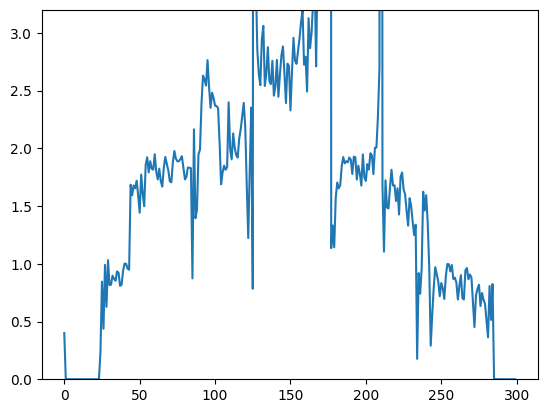

In [71]:
plt.plot(data_test[7][0])
plt.ylim(0,3.2)

Text(0.5, 0, 'conc')

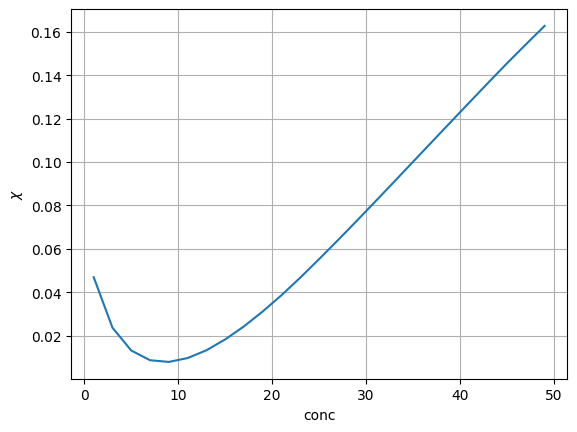

In [95]:
plt.plot(np.arange(1,50,2),[np.sum((np.abs(np.array(data_test[7][0]) - ca(con)[0])[:100])**2)/300 for con in np.arange(1,50,2)])
plt.grid()
plt.ylabel(r'$\chi$')
plt.xlabel('conc')